**Requirements:**
* Trained models

**Outputs:** 
* none 
___
# Imports

In [1]:

import matplotlib
import umap.plot
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

from anndata import AnnData

from chemCPA.paths import FIGURE_DIR, ROOT
from chemCPA.data import load_dataset_splits
from utils import load_config, load_dataset, load_smiles, load_model, compute_drug_embeddings, compute_pred, compute_pred_ctrl

[Using backend: pytorch17:43:13] /opt/dgl/src/runtime/tensordispatch.cc:43: TensorDispatcher: dlopen failed: /home/icb/leon.hetzel/miniconda3/envs/chemical_CPA/lib/python3.7/site-packages/dgl/tensoradapter/pytorch/libtensoradapter_pytorch_1.10.1.so: cannot open shared object file: No such file or directory



In [2]:
BLACK = False
SAVEFIG = False

In [3]:
if BLACK: 
    plt.style.use('dark_background')
else: 
    matplotlib.style.use("fivethirtyeight")
    matplotlib.style.use("seaborn-talk")
    matplotlib.pyplot.rcParams['savefig.facecolor'] = 'white'
    sns.set_style("whitegrid")

matplotlib.rcParams['font.family'] = "monospace"
matplotlib.rcParams['figure.dpi'] = 300
sns.set_context("poster")

In [4]:
%load_ext autoreload
%autoreload 2

## Plotting function

In [136]:
def plot_umap(mapper,
              canon_smiles_unique_sorted, 
              smiles_to_pathway_map, 
              smiles_to_drug_map,
              groups=["Epigenetic regulation", "Tyrosine kinase signaling", "Cell cycle regulation"],
              ood_drugs = [],
              hue= None,
              ax=None
             ): 
    # important to use the same ordering of SMILES as was used for getting the embedding!
    if ax == None: 
        fig, ax = plt.subplots(figsize=(12,8))
    
    # groups=["Tyrosine kinase signaling"]
    pathway = []
    drugs = []

    for s in canon_smiles_unique_sorted:
        if s in smiles_to_pathway_map: 
            pathway.append(smiles_to_pathway_map[s])
            drugs.append(smiles_to_drug_map[s])
        else: 
            pathway.append('other')
            drugs.append('unknown')
    
    pathway = np.where(pd.Series(pathway).isin(groups), pathway, "other")
    
#     cmap = [(0.7,0.7,0.7)]
# #     cmap.extend(list(plt.get_cmap('tab20').colors))
# #     cmap = tuple(cmap)

#     sns.scatterplot(x=mapper[:,0], y=mapper[:,1], hue=pathway, palette=cmap, ax=ax)
    if hue is None: 
        cond = pathway != 'other'
        sns.scatterplot(x=mapper[cond,0], y=mapper[cond,1], hue=pathway[cond], ax=ax, palette='tab10' if BLACK else None)
        sns.scatterplot(x=mapper[~cond,0], y=mapper[~cond,1], ax=ax, color='grey', alpha=0.3)
    else: 
        sns.scatterplot(x=mapper[:,0], y=mapper[:,1], hue=hue, ax=ax)
        
    shift = 0.75
    for i, label in enumerate(drugs):
        if drugs[i] in ood_drugs: 
            ax.text(
                x=mapper[i,0]+shift, 
                y=mapper[i,1]+shift,
                s=label,
                fontdict=dict(color='white' if BLACK else 'black', alpha=1, size=16, weight=600),
                bbox=dict(facecolor='black' if BLACK else 'lightgrey', alpha=0.3),
            )
            x = mapper[i,0]
            y = mapper[i,1]
            ax.annotate("", 
                        xy=(x, y), 
                        xytext=(x+shift, y+shift),
                        arrowprops=dict(arrowstyle="->",
#                                         facecolor='black',
                                        edgecolor='black',),
#                         fontdict=dict(color='white' if BLACK else 'black', alpha=1, size=12, weight=600),
#                         bbox=dict(facecolor='black' if BLACK else 'lightgrey', alpha=0.3)
                       )
            
            

# Load and analyse model 
* Define `seml_collection` and `model_hash` to load data and model

In [6]:
# Extended 
seml_collection = "multi_task"

model_hash_pretrained_rdkit = "dde01c1c58f398d524453c4b564a440f" # Fine-tuned 
model_hash_scratch_rdkit = "475e26950b2c531bea88931a4b2c27b7" # Non-pretrained

model_hash_pretrained_grover = "0f4a3b11e1fbe3da58125f39ff6fb035" # Fine-tuned
model_hash_scratch_grover = "b372147c80cf9ad4bd10d16bc56b7534" # Non-pretrained

model_hash_pretrained_jtvae = "e4eac660c5830245f681ec3cc5099f21" # Fine-tuned
model_hash_scratch_jtvae = "6b465400467f69da861e3ef0b4709e19" # Non-pretrained


# SHARED
seml_collection = "multi_task"

model_hash_pretrained_rdkit = "c824e42f7ce751cf9a8ed26f0d9e0af7" # Fine-tuned 
model_hash_scratch_rdkit = "59bdaefb1c1adfaf2976e3fdf62afa21" # Non-pretrained

model_hash_pretrained_grover = "c30016a7469feb78a8ee9ebb18ed9b1f" # Fine-tuned
model_hash_scratch_grover = "60e4b40e8d67bff2d5efc5e22e265820" # Non-pretrained

model_hash_pretrained_jtvae = "915345a522c29fa709b995d6149083b9" # Fine-tuned
model_hash_scratch_jtvae = "934c89b742a6309ad6bb2e1cf90c5e50" # Non-pretrained

In [7]:
model_hash_pretrained = model_hash_pretrained_rdkit

___
## Pretrained model

### Load model

In [8]:
config = load_config(seml_collection, model_hash_pretrained)

config["dataset"]["data_params"]["dataset_path"] = ROOT / config["dataset"]["data_params"]["dataset_path"]
config["model"]["embedding"]["directory"] = ROOT / config["model"]["embedding"]["directory"]

dataset, key_dict = load_dataset(config)

config['dataset']['n_vars'] = dataset.n_vars

canon_smiles_unique_sorted, smiles_to_pathway_map, smiles_to_drug_map = load_smiles(config, dataset, key_dict, True)
model_pretrained, embedding_pretrained = load_model(config, canon_smiles_unique_sorted)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

#### Define which drugs should be annotaded with list `ood_drugs`

In [9]:
ood_drugs = dataset.obs.condition[dataset.obs.split_ood_multi_task.isin(['ood'])].unique().to_list()

In [10]:
ood_drugs

['Quisinostat',
 'Hesperadin',
 'Flavopiridol',
 'Belinostat',
 'Alvespimycin',
 'TAK-901',
 'Dacinostat',
 'Tanespimycin',
 'Givinostat']

#### Get pathway level 2 annotation for clustering of drug embeddings

In [11]:
smiles_to_pw_level2_map = {}
pw1_to_pw2 = {}

for (drug, pw1, pw2), df in dataset.obs.groupby(['SMILES', 'pathway_level_1', 'pathway_level_2']): 
    smiles_to_pw_level2_map[drug] = pw2
    if pw1 in pw1_to_pw2:
        pw1_to_pw2[pw1].add(pw2)
    else: 
        pw1_to_pw2[pw1] = {pw2}

# Compute drug perturbation (RDKit)

In [12]:
transf_embeddings_pretrained_high = compute_drug_embeddings(model_pretrained, embedding_pretrained, dosage=1e4)
mapper_pretrained_high = umap.UMAP(n_neighbors=25, min_dist=1, spread=2, metric='euclidean').fit_transform(transf_embeddings_pretrained_high)

transf_embeddings_pretrained_low = compute_drug_embeddings(model_pretrained, embedding_pretrained, dosage=10)
mapper_pretrained_low = umap.UMAP(n_neighbors=25, min_dist=1, spread=2).fit_transform(transf_embeddings_pretrained_low)

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


# Plot pretrained RDKit fingerprints

In [13]:
drug_emb_pretrained = np.array(embedding_pretrained.weight.data)

In [14]:
for s, pw in smiles_to_pw_level2_map.items(): 
    if pw == "Histone deacetylation":
        smiles_to_pathway_map[s] = pw

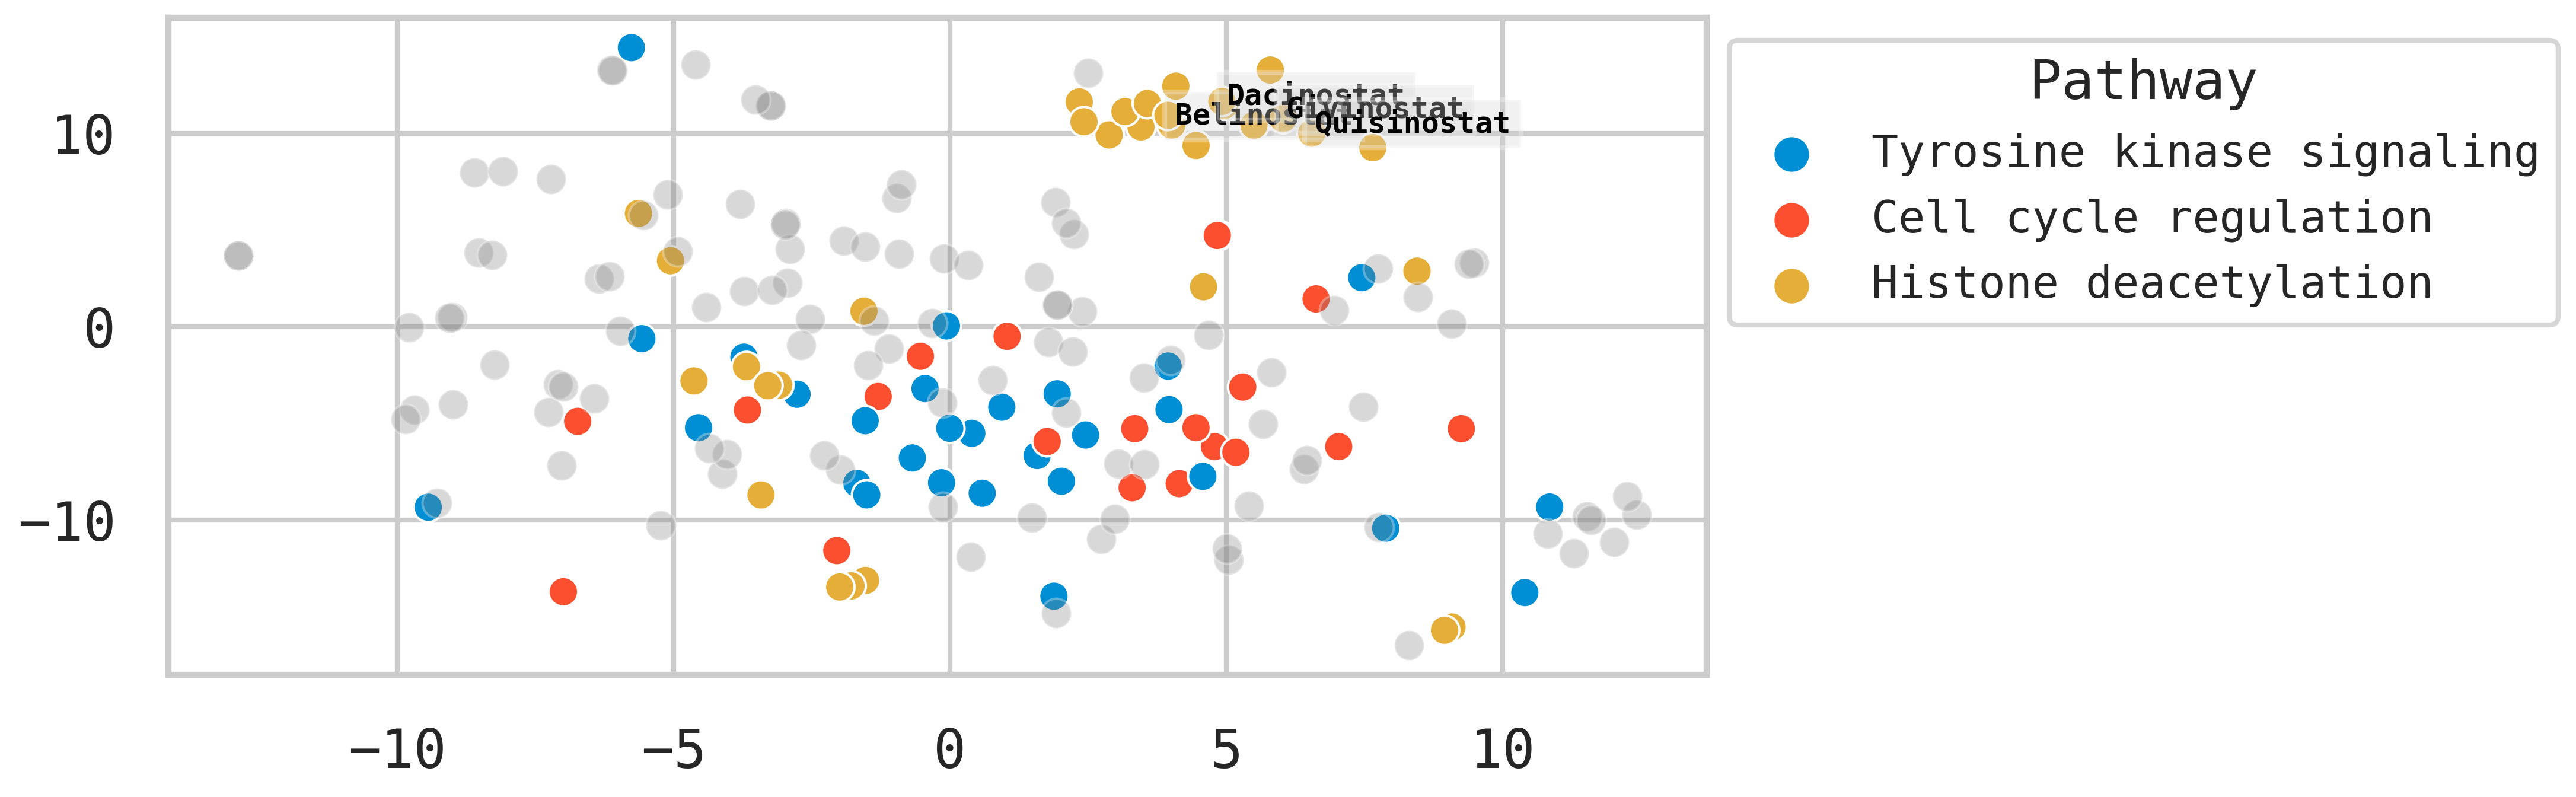

In [15]:
SAVEFIG = True

drugs_label = [
    'Quisinostat',
    # 'Hesperadin',
    # 'Flavopiridol',
    'Belinostat',
    # 'Alvespimycin',
    # 'TAK-901',
    'Dacinostat',
    # 'Tanespimycin',
    'Givinostat']

_groups = [
    'Histone deacetylation',
    'Cell cycle regulation',
    'Tyrosine kinase signaling',
]

fig, ax = plt.subplots(1,1, figsize=(15,5))

plot_umap(
    TSNE().fit_transform(drug_emb_pretrained),
    canon_smiles_unique_sorted, 
    smiles_to_pathway_map, 
    smiles_to_drug_map,
    groups = _groups,
    ood_drugs=drugs_label,
    ax=ax,
)
ax.legend(title='Pathway', fontsize=18, title_fontsize=22, loc="upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()

if SAVEFIG: 
    if BLACK:
        plt.savefig(FIGURE_DIR/'rdkit_pretrained_drug_embedding_balck.png', format='png')
    else: 
        plt.savefig(FIGURE_DIR/'rdkit_pretrained_drug_embedding.png', format='png')
        
SAVEFIG = False

_____

# Uncertainty 

In [16]:
drug_emb = transf_embeddings_pretrained_high

adata = AnnData(drug_emb.numpy())
adata.X = StandardScaler().fit_transform(drug_emb)


drugs = [smiles_to_drug_map[s] for s in canon_smiles_unique_sorted]
adata.obs['drug'] = drugs 
adata.obs['pathway'] = [smiles_to_pathway_map[s] for s in canon_smiles_unique_sorted]
adata.obs['split'] = 'train'
adata.obs.loc[adata.obs.drug.isin(ood_drugs), 'split'] = 'ood'

Preprocess adata object

In [17]:
sc.pp.pca(adata, n_comps=15)

Baseline score

In [18]:
data_params = config['dataset']['data_params']
datasets, dataset_all = load_dataset_splits(**data_params, return_dataset=True)

In [19]:
dosages = [1e1,1e2,1e3,1e4]
dosages = [1e4]
cell_lines = ["A549", "K562", "MCF7"]
use_DEGs = True

In [20]:
drug_r2_baseline_degs, _ = compute_pred_ctrl(dataset=dataset_all, #dataset_test_ood,
                                        dataset_ctrl=datasets['test_control'],
                                        dosages=dosages,
                                        cell_lines=cell_lines,
                                        use_DEGs=True,
                                        verbose=False,
                                       )


['A549', 'K562', 'MCF7']


0it [00:00, ?it/s]

In [21]:
baseline_key = pd.Series(drug_r2_baseline_degs.keys())
baseline_val = pd.Series(drug_r2_baseline_degs.values())

adata.obs['baseline_perf'] = ""

for d in adata.obs.drug: 
    cond = baseline_key.apply(lambda s: d in s)
    adata.obs.loc[adata.obs.drug==d, 'baseline_perf'] = baseline_val[cond].mean()

# baseline_val

Pretrained model score

In [22]:
drug_r2_pretrained_degs, _ = compute_pred(model_pretrained, 
                                     dataset_all, 
                                     genes_control=datasets['test_control'].genes, 
                                     dosages=dosages,
                                     cell_lines=cell_lines,
                                     use_DEGs=True,
                                     verbose=False,
                                    )

['A549', 'K562', 'MCF7']


0it [00:00, ?it/s]

In [23]:
pretrained_key = pd.Series(drug_r2_pretrained_degs.keys())
pretrained_val = pd.Series(drug_r2_pretrained_degs.values())

adata.obs['pretrained_perf'] = ""

for d in adata.obs.drug: 
    cond = pretrained_key.apply(lambda s: d in s)
    adata.obs.loc[adata.obs.drug==d, 'pretrained_perf'] = pretrained_val[cond].mean()

# pretrained_val

In [24]:
adata.obs['difference'] = adata.obs.pretrained_perf - adata.obs.baseline_perf

Compute knn-graph, neighbours, and distances

In [25]:
sc.pp.neighbors(adata, n_neighbors=10)

In [26]:
neighbours = np.where(adata.uns['neighbors']['distances'].A !=0)
distances = adata.obsp['distances'].A

In [27]:
def entropy(column, base=None):
    vc = pd.Series(column).value_counts(normalize=True, sort=False)
    base = np.exp if base is None else base
    return -(vc * np.log(vc)/np.log(base)).sum()


In [28]:
adata.obs['n_neighbours'] = ""
adata.obs['pathway_acc'] = ""
adata.obs['neighbor_pred'] = ""
adata.obs['correct'] = ""

for i in range(188): 
    cond = neighbours[0]==i
    pathway = adata.obs.pathway.iloc[i]
    pathways = adata.obs.pathway.iloc[neighbours[1][cond]]
    baselines = adata.obs.baseline_perf.iloc[neighbours[1][cond]]
    adata.obs.loc[adata.obs.drug == adata.obs.drug.iloc[i],'n_neighbours'] = len(pathways)
    # adata.obs.loc[adata.obs.drug == adata.obs.drug.iloc[i],'pathway_acc'] = (pathway==pathways).sum()/len(pathways)
    pw, count = np.unique(pathways, return_counts=True)
    # adata.obs.loc[adata.obs.drug == adata.obs.drug.iloc[i], 'neighbor_pred'] = pw[count.argmax()]
    # adata.obs.loc[adata.obs.drug == adata.obs.drug.iloc[i], 'pw_pred_count'] = count.max()/len(pathways)
    # adata.obs.loc[adata.obs.drug == adata.obs.drug.iloc[i], 'correct'] = 1 if pw[count.argmax()]==pathway else 0
    # adata.obs.loc[adata.obs.drug == adata.obs.drug.iloc[i], 'baseline_neighbors'] = baselines.mean()
    adata.obs.loc[adata.obs.drug == adata.obs.drug.iloc[i], 'heterogeneity'] = len(pw)
    # if adata.obs.drug.iloc[i] in ood_drugs: 
    #     print(distances[i].sum())
    #     print(entropy(pathways, base=2))
    adata.obs.loc[adata.obs.drug == adata.obs.drug.iloc[i], 'uncertainty'] = 1/np.log(distances[i].sum()) * entropy(pathways, base=2)
    adata.obs.loc[adata.obs.drug == adata.obs.drug.iloc[i], 'distance'] = distances[i].sum()

## Table 4

In [29]:
cols = [
    "drug",
    'distance',
    'difference',
    'uncertainty'
]

print(adata.obs.loc[adata.obs.drug.isin(ood_drugs), cols].sort_values('uncertainty').to_latex())

\begin{tabular}{llrlr}
\toprule
{} &          drug &   distance & difference &  uncertainty \\
\midrule
50  &    Dacinostat &  36.983122 &   0.570354 &    -0.000000 \\
77  &    Givinostat &  32.410247 &   0.660127 &    -0.000000 \\
31  &    Belinostat &  57.808130 &   0.623305 &     0.124043 \\
79  &    Hesperadin &  37.903420 &   0.197494 &     0.397964 \\
129 &   Quisinostat &  30.053367 &   0.052033 &     0.645659 \\
16  &  Alvespimycin &  26.399045 &   0.058353 &     0.739120 \\
160 &  Tanespimycin &  18.589066 &   0.092015 &     0.827826 \\
155 &       TAK-901 &  17.030181 &   0.049301 &     0.882988 \\
69  &  Flavopiridol &   9.009948 &   0.011212 &     0.999468 \\
\bottomrule
\end{tabular}



## Supplement Figure 14

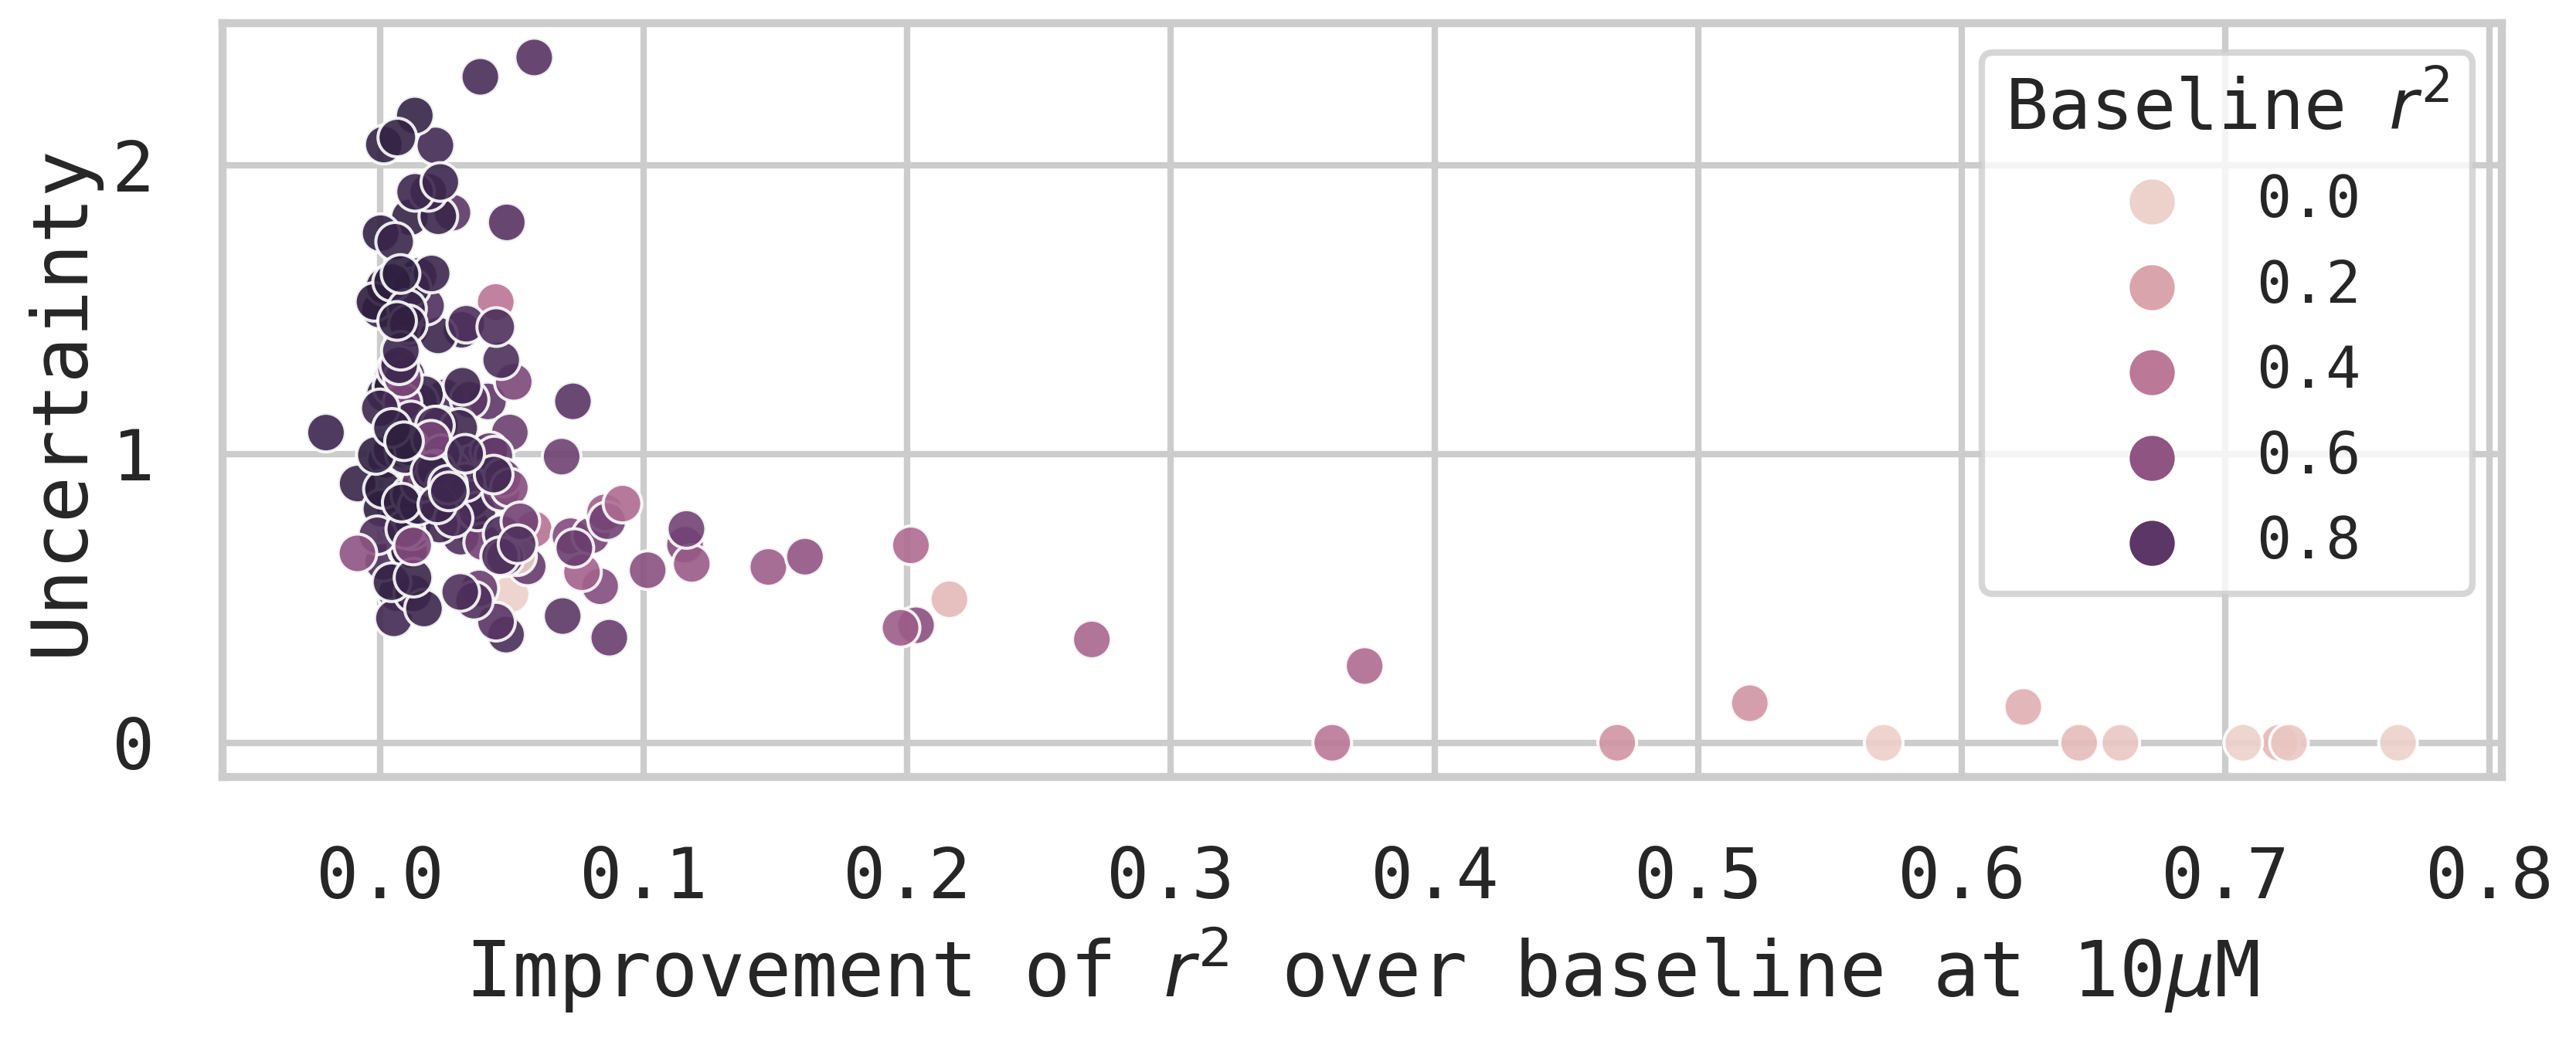

In [30]:
SAVEFIG = False
fig, ax = plt.subplots(figsize=(12,5))
sns.scatterplot(data=adata.obs, x='difference', y='uncertainty',ax=ax, hue='baseline_perf', alpha=0.9)
ax.set_xlabel(r"Improvement of $r^2$ over baseline at 10$\mu$M")
ax.set_ylabel("Uncertainty")
ax.legend(title=r'Baseline $r^2$', fontsize=18, title_fontsize=22, loc="best")
plt.tight_layout()

if SAVEFIG: 
    if BLACK:
        plt.savefig(FIGURE_DIR/'uncertainty_drug_embedding_balck.png', format='png')
    else: 
        plt.savefig(FIGURE_DIR/'uncertainty_drug_embedding.png', format='png')
SAVEFIG = False    

In [39]:
adata.obsm['umap'] = mapper_pretrained_high

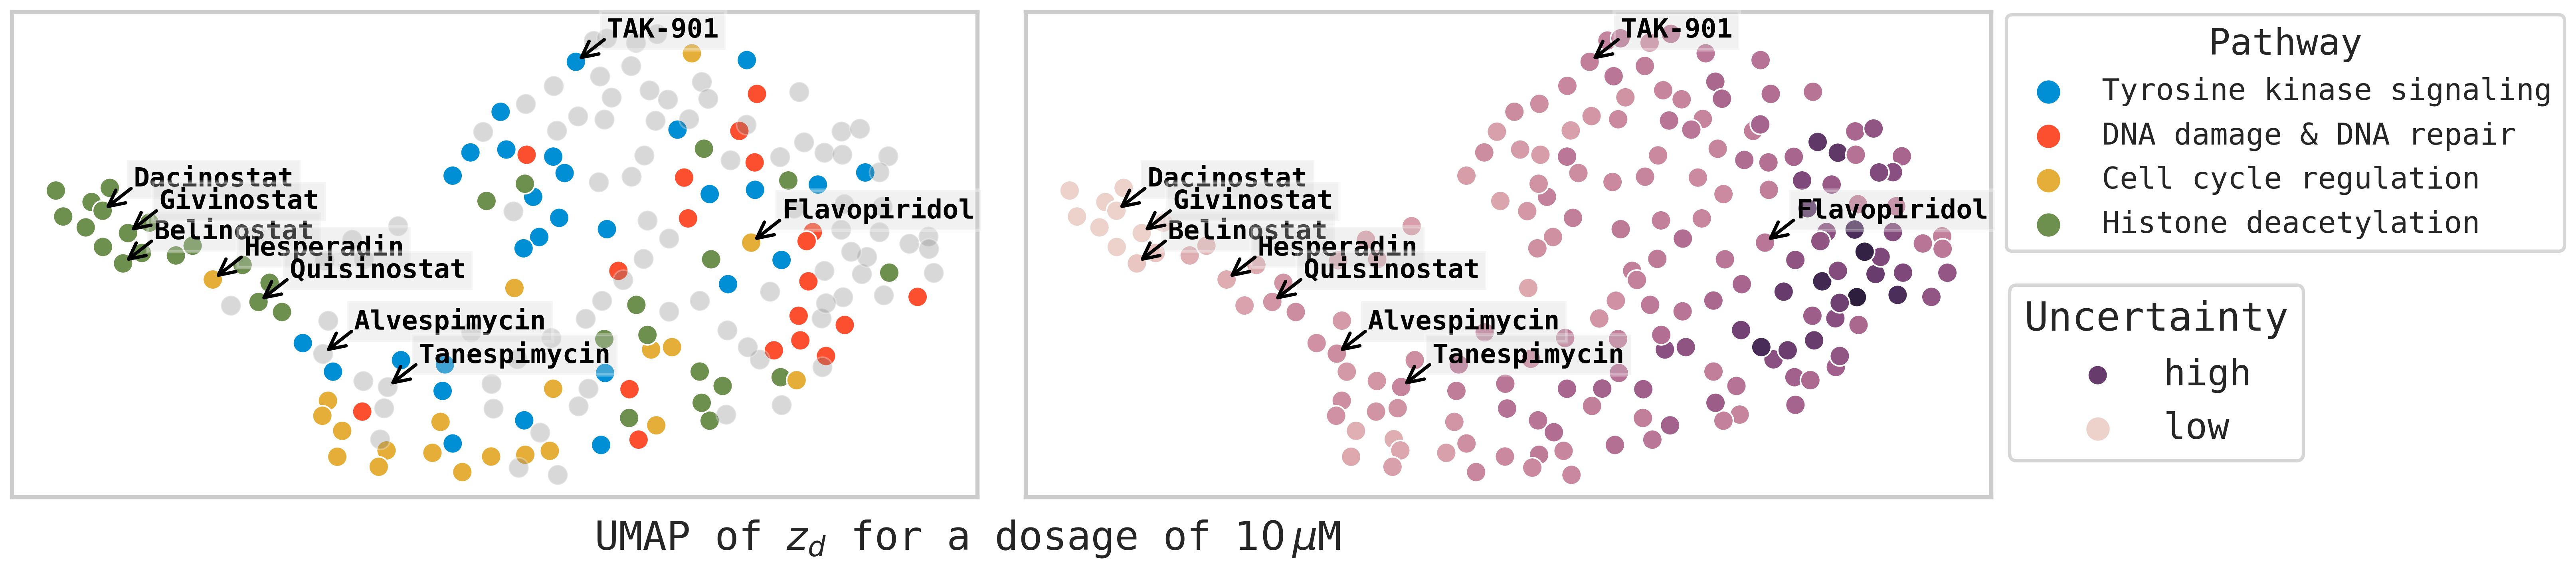

In [137]:
SAVEFIG = True



groups = [
    "Histone deacetylation",
    "Tyrosine kinase signaling",
    "Cell cycle regulation",
    "DNA damage & DNA repair"
]


fig, ax = plt.subplots(1,2, figsize=(19,5), sharex=True)

plot_umap(
    mapper_pretrained_high,
    canon_smiles_unique_sorted, 
    smiles_to_pathway_map, 
    smiles_to_drug_map,
    groups = groups,
    ood_drugs=ood_drugs,
    ax=ax[0]
)

uncertainty = adata.obs['uncertainty'].values
plot_umap(
    mapper_pretrained_high,
    canon_smiles_unique_sorted, 
    smiles_to_pathway_map, 
    smiles_to_drug_map,
    groups = [""],
    hue = uncertainty, 
    ood_drugs=ood_drugs,
    ax=ax[1]
)


ax[1].set(xticklabels=[], yticklabels=[])
# ax[1].set_xlabel(f"UMAP of $z_d$ for a dosage of $10\,\mu$M")
ax[1].legend(title='Uncertainty', labels=['high', 'low'], loc="lower left", bbox_to_anchor=(0.95, 0.1), bbox_transform=fig.transFigure)

ax[0].set(xticklabels=[], yticklabels=[])

ax[0].grid(False)
ax[1].grid(False)
# ax[0].get_legend().remove()
ax[0].legend(title='Pathway', fontsize=18, title_fontsize=22, loc="upper left", bbox_to_anchor=(0.95, 0.9), bbox_transform=fig.transFigure)

# plt.tight_layout()
plt.subplots_adjust(wspace=0.05, hspace=0.05)
# fig.supxlabel(f"UMAP of $z_d$ for a dosage of $10\,\mu$M")
fig.text(0.5, 0.0, f"UMAP of $z_d$ for a dosage of $10\,\mu$M", ha='center', va='center')

if SAVEFIG: 
    if BLACK:
        plt.savefig(FIGURE_DIR/'umap_drug_embedding_uncertainty_black.png', format='png')
    else: 
        plt.savefig(FIGURE_DIR/'umap_drug_embedding_uncertainty.png', format='png', bbox_inches="tight")